In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler, MinMaxScaler
import seaborn as sns
import matplotlib.pyplot as plt
import os
import time
from sklearn.utils.class_weight import compute_class_weight
import shap
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score, precision_score, recall_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.model_selection import train_test_split
import random
from sklearn.cluster import KMeans, DBSCAN
from sklearn.decomposition import PCA
from scipy.stats import multivariate_normal
from sklearn.manifold import TSNE
from sklearn.utils import resample

In [2]:
class PlotClusters:
    """
    PlotClusters: A class that plots different clusters in a 3-D plot with augmentations. Easily evaluate K-means++ clusters or use DBSCAN to seperate noise from other clusters.
    Use either just the normal Kmeans++ to 3D or DBSCAN to 3D or optionally project it through TSNE. Makes it easy to quickly visualise within label groups.

    Initialisation:
        - data (pd.DataFrame): The Dataset to analyse which should have the labels filtered out.
        - scaler_type (string): Either use 'standard' or 'minmax' scaler.
        - sample_size (int): Sample a smaller size - increasing this to above 10000 significantly increasing computation for TSNE.
    """
    def __init__(self, data, scaler_type, sample_size):
        self.data = data.copy()
        features = ['dur', 'sbytes', 'dbytes', 'sttl', 'dttl', 'sloss', 'dloss', 'Sload', 'Dload', 'Spkts', 'Dpkts',
                   'swin', 'dwin', 'stcpb', 'dtcpb', 'smeansz', 'dmeansz', 'trans_depth', 'res_bdy_len', 'Sjit',
                   'Djit', 'Stime', 'Ltime', 'Sintpkt', 'Dintpkt', 'tcprtt', 'synack', 'ackdat', 'ct_srv_src', 
                   'ct_srv_dst', 'ct_dst_ltm', 'ct_src_ltm', 'ct_src_dport_ltm', 'ct_dst_sport_ltm', 'ct_dst_src_ltm']
        self.data = self.data[features]
        # NOTE: Scaling seems to have a large impact on the number of clusters that are formed.
        if scaler_type == 'minmax':
            self.scaler = MinMaxScaler()
        elif scaler_type == 'standard':
            self.scaler = StandardScaler()
        scaled_data = self.scaler.fit_transform(self.data)
        # Resample to a more manageable size. TSNE takes a very long time.
        self.data = resample(scaled_data, n_samples=sample_size, random_state=42)

    def plot_tsne(self, apply_pca=False, n_clusters=2, lr='auto', perplexity=30, cluster_type='kmeans', eps=0.5, min_samples=20):
        """
        plot_tsne: Use KMeans++ or DBSCAN clustering and visualisate it using 3 TSNE components in a 3D map. Augments the graph for more clear interpretations.
        
        Parameters:
        - apply_pca: Whether to apply PCA before t-SNE.
        - n_clusters: Number of clusters for KMeans++ clustering.
        - lr: Learning rate for t-SNE.
        - cluster_type: Clustering type ('kmeans' or 'dbscan').
        - eps: Epsilon for DBSCAN (a type of threshold for noise which specifies the size of the ring).
        - min_samples: Minimum amount of neighbouring points or rows to consider.

        """
        # NOTE: PCA is optional as TSNE can already project the data into 3D space. PCA can speed up the processing for TSNE
        # which is complex for high dimensional data.
        data = self.data
        if apply_pca:
            pca = PCA(n_components=3)
            data = pca.fit_transform(data)
            # Print Explainability of PCA components.
            print(f"Explained Variance Ratio (PCA): {np.sum(pca.explained_variance_ratio_):.4f}")

        # Apply clustering (KMeans or DBSCAN).
        if cluster_type == 'kmeans':
            kmeans = KMeans(n_clusters=n_clusters, random_state=42)
            kmeans_labels = kmeans.fit_predict(data)
            labels = kmeans_labels
        elif cluster_type == 'dbscan':
            dbscan = DBSCAN(eps=eps, min_samples=min_samples)
            dbscan_labels = dbscan.fit_predict(data)
            labels = dbscan_labels

        # Transform into a 3D space using TSNE.
        tsne = TSNE(n_components=3, random_state=42, learning_rate=lr, perplexity=perplexity)
        tsne_data = tsne.fit_transform(data)
        # Error occurs using numpy so needs to be converted.
        tsne_df = pd.DataFrame(tsne_data, columns=['v1', 'v2', 'v3'])
        tsne_df['Cluster'] = labels
        # Rotatation for the plots.
        sns.set_theme(palette="pastel")
        fig = plt.figure(figsize=(12, 10))
        views = [
            (30, 30),
            (90, 0),
            (-90, 0),
            (30, 90),
        ]
        
        for i, (elev, azim) in enumerate(views):
            ax = fig.add_subplot(2, 2, i+1, projection='3d')

            # Plots noise (-1) in red, others in a different color. Set alpha to low as it is usually the hard to see other points amongst it.
            if cluster_type == 'dbscan':
                ax.scatter(tsne_df['v1'][tsne_df['Cluster'] == -1], 
                           tsne_df['v2'][tsne_df['Cluster'] == -1], 
                           tsne_df['v3'][tsne_df['Cluster'] == -1], 
                           color='#E45E4C', label='Noise', s=50, alpha=0.1, edgecolors='#A11E0C')

                ax.scatter(tsne_df['v1'][tsne_df['Cluster'] != -1], 
                           tsne_df['v2'][tsne_df['Cluster'] != -1], 
                           tsne_df['v3'][tsne_df['Cluster'] != -1], 
                           c=tsne_df['Cluster'][tsne_df['Cluster'] != -1], 
                           cmap='tab20', s=50, alpha=0.8)

            # If KMeans, plot each cluster with a different color
            if cluster_type == 'kmeans':
                ax.scatter(tsne_df['v1'], tsne_df['v2'], tsne_df['v3'], 
                                     c=tsne_df['Cluster'], cmap='tab20', s=100, alpha=0.3, marker='o')

            ax.view_init(elev=elev, azim=azim)
        plt.suptitle(f"TSNE with {cluster_type.capitalize()}")
        plt.tight_layout()
        plt.show()

    def plot_dbscan(self, eps=0.5, min_samples=20):
        """
        plot_tsne:  DBSCAN clustering and visualisate it using 3 PCA components in a 3D map. Augments the graph for more clear interpretations.
        
        Parameters:
        - eps: Epsilon for DBSCAN (a type of threshold for noise which specifies the size of the ring).
        - min_samples: Minimum amount of neighbouring points or rows to consider.

        """

        data = self.data
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        dbscan_labels = dbscan.fit_predict(data)

        # PCA is required for the 3D plot.
        pca = PCA(n_components=3)
        data = pca.fit_transform(data)
        # Print Explainability of PCA components.
        print(f"Explained Variance Ratio (PCA): {np.sum(pca.explained_variance_ratio_):.4f}")
        
        # Prepare DataFrame for plotting
        pca_data = pd.DataFrame(data, columns=['PC1', 'PC2', 'PC3'])
        pca_data['Cluster'] = dbscan_labels
        sns.set_theme(palette="pastel")
        fig = plt.figure(figsize=(12, 10))
        
        # Rotation of plot.
        views = [
            (30, 30),
            (90, 0),
            (-90, 0),
            (30, 90),
        ]
        
        for i, (elev, azim) in enumerate(views):
            ax = fig.add_subplot(2, 2, i+1, projection='3d')
            # Set noise to red. Alpha is set to be able to see the other clusters easier.
            ax.scatter(pca_data['PC1'][dbscan_labels == -1], pca_data['PC2'][dbscan_labels == -1], pca_data['PC3'][dbscan_labels == -1], 
                       color='#E45E4C', label='Noise', s=50, alpha=0.1, edgecolors='#A11E0C')

            ax.scatter(pca_data['PC1'][dbscan_labels != -1], pca_data['PC2'][dbscan_labels != -1], pca_data['PC3'][dbscan_labels != -1], 
                       c=dbscan_labels[dbscan_labels != -1], cmap='tab20', s=50, alpha=0.4)
            ax.view_init(elev=elev, azim=azim)
            ax.legend()
        plt.suptitle('DBSCAN Noise Clusters 3D PCA')
        plt.tight_layout()
        plt.show()

    def plot_kmeans(self, n_clusters=2):
        """
        plot_kmeans: Kmeans clustering and visualisate it using 3 PCA components in a 3D map. Augments the graph for more clear interpretations.

        Parameters:
            - n_clusters (integer): The number of clusters to try and seperarte using Kmeans++.
        """
        data = self.data

        kmeans = KMeans(n_clusters=n_clusters, random_state=42)
        kmeans_labels = kmeans.fit_predict(data)
        # PCA is required for 3D plot.
        pca = PCA(n_components=3)
        pca_data = pca.fit_transform(data)
        # Print explainability of PCA components.
        print(f"Explained Variance Ratio (PCA): {np.sum(pca.explained_variance_ratio_):.4f}")
        sns.set_theme(palette="pastel")
        fig = plt.figure(figsize=(12, 10))
        # Rotation of plot.
        views = [
            (30, 30),
            (90, 0),
            (-90, 0),
            (30, 90),
        ]
        
        for i, (elev, azim) in enumerate(views):
            ax = fig.add_subplot(2, 2, i+1, projection='3d')
            ax.scatter(pca_data[:, 0], pca_data[:, 1], pca_data[:, 2], c=kmeans_labels, 
                                 cmap='tab20', s=100, alpha=0.3, marker='o')
            ax.view_init(elev=elev, azim=azim)
        plt.suptitle('Kmeans Clusters 3D PCA')
        plt.tight_layout()
        plt.show()

In [3]:
class CorrEncoder:
    """
    CorrEncoder: Takes a dataset as input and uses it for the encode function. Encodes the filtered categories then draws correlations.
    If correlation is above the threshold adds it to a new dataframe then returns the one hot encoded values with the labels.

    Initialisation:
        - data (pd.DataFrame): The Dataset that contains the target column and target label variables.
    """
    
    def __init__(self, data):
        self.data = data.copy()
        # Removes Label for the multi-class processing as it is based on the label category (threat or not).
        self.data = self.data.drop(columns=['attack_cat'])

    def encode(self, target_column, sparse_n, threshold, print_data):
        """
        encode: Takes a target column and target label to encode and draw correlations from. The target column is iterated through
        for all categories that contain more positive values than defined in sparse_n. This allows for filtering of sparse categories.
        The function then one hot encodes the given category with the static target column and draws correlations for them. If correlation
        is greater then threshold then add it to the new DataFrame. The function returns the one hot encoded categories that pass the
        threshold with the target label.

        The purpose of this function is to resolve the high cardinality problem in one hot encoding.

        Parameters:
            - target_column (string): The name of the target column. The target column should contain the various categories to encode.
            - sparse_n (integer): The minimum amount of positive values required for a category after encoding (deals with sparse categories).
            - threshold (float): The threshold for correlation. The function creates onehot encoded columns of all variables that have correlation
              higher that the threshold to the target label.

        Returns:
            - ohe_df (pd.DataFrame): The one hot encoded values from the target column.
        """

        # Convert to string to handle duplicates.
        self.data[target_column] = self.data[target_column].astype(str)
        value_counts = self.data[target_column].value_counts()
        # Check if number of 1s is above the given threshold set by sparse_n.
        categories = value_counts[value_counts > sparse_n].index.tolist()
        ohe_list = []

        # Attack category (target label)
        attack_cat = self.data['Label']
        
        # Go through each unique category in the target column.
        for c in categories:
            col_name = f'{target_column}_{c}'

            # Create the binary encoding column for the current category and target label.
            corr_column = (self.data[target_column] == c).astype(int)
            correlation = corr_column.corr(attack_cat)

            # Check if absolute correlation is greater than threshold.
            if abs(correlation) > threshold:
                corr_column.name = col_name
                ohe_list.append(corr_column)
        if print_data:
            print('Number of Encoded Features for', target_column)
            print(len(ohe_list))
        if ohe_list:
            # NOTE: This section can be expanded to include print outs but at the moment am focusing on the evaluations.
            ohe_df = pd.concat(ohe_list, axis=1)
            return ohe_df
        else:
            return pd.DataFrame()

In [4]:
def check_sample_labels(data1, data2, estimators, sample_size):
    """
    check_sample_labels: Create a number of samples given by estimators of a given sample size. Then sample two different dataframes to compare the
    value counts for labels. Finds the amount of discrepency between using non-stratified random sampling methods. Prints the averages of the unique counts of labels.

    Parameters:
        - data1 (pd.DataFrame): The first dataframe to compare.
        - data2 (pd.DataFrame): The alternative dataframe to compare.
        - estimators (int): The number of times to sample and create an average from.
        - sample_size (int): The size of each sample.
    """
    sample_size = min(sample_size, len(data1), len(data2))
    
    len1 = 0
    len2 = 0
    for i in range(estimators):
        sample1 = data1.sample(n=sample_size, replace=False)
        sample2 = data2.sample(n=sample_size, replace=False)
        count1 = sample1['attack_cat'].value_counts()
        count2 = sample2['attack_cat'].value_counts()
        len1 += len(count1)
        len2 += len(count2)
    print('Full Data:')
    print(f"Average Count of Labels {(len1/estimators)} with {estimators} estimators of size {sample_size}")
    print('Down-sampled Data:')
    print(f"Average Count of Labels Downsampled Data: {(len2/estimators)} with {estimators} estimators of size {sample_size}")

In [5]:
def get_data(size, rs, threshold, downsample, split_method, scaler_type, plot_clusters):
    """
    get_data: Preprocess and transform data.
    
    Parameters:
        - size (integer): The size of the validation set.
        - rs (int): The random seed to use for sampling and slicing.
        - threshold (float): The threshold for correlation when one hot encoding.
        - downsample (string, float): Either 'full' or a probability of how much to downsample the labels.
        - split_method (string): Slice or sample the data for the validation set.

    Returns:
        - train_data (pd.DataFrame): The train dataset with labels.
        - val_data (pd.DataFrame): The validation dataset with labels.
    """

    feature_names = pd.read_csv(f'../features2.csv')
    #self.name = category
    feature_names_list = feature_names['Name'].tolist()
    datasets = []
    removed_rows_list = []
    normal_data = []
    # Create a list of datasets.
    for i in range(1, 5):
        df = pd.read_csv(f'../UNSW-NB15_{i}.csv', header=None)
        df.columns = feature_names_list
        df.loc[df['attack_cat'].isnull(), 'attack_cat'] = 'Normal'
        datasets.append(df)

    # Process each dataset individually this can be increased to more datasets.
    for i in range(len(datasets)):
        print('Dataset', i)
        df = datasets[i]
        # Clean the dataset
        length1 = len(df)
        df.columns = df.columns.str.replace(' ', '')
        df['attack_cat'] = df['attack_cat'].str.replace(r'\s+', '', regex=True)
        df['attack_cat'] = df['attack_cat'].str.replace('Backdoors', 'Backdoor')
        df = df[~df['sport'].astype(str).str.startswith('0x')]
        df = df[~df['dsport'].astype(str).str.startswith('0x')]
        # Does not align with the Features CSV description?
        #df = df.drop(columns=['is_ftp_login'])
        df['ct_ftp_cmd'] = df['ct_ftp_cmd'].astype(str)
        df['ct_ftp_cmd'] = df['ct_ftp_cmd'].replace(' ', 0)
        df['ct_ftp_cmd'] = df['ct_ftp_cmd'].astype(int)
        df['is_ftp_login'] = df['is_ftp_login'].fillna(0)
        df['is_ftp_login'] = np.where(df['is_ftp_login']>1, 1, df['is_ftp_login'])
        df['ct_flw_http_mthd'] = df['ct_flw_http_mthd'].fillna(0).astype(int)
        print(f"Filtered Rows (Cleaning): {length1 - len(df)}")
        # Full downsampling by matching Normal to Threat (Label).
        if downsample == 'full':
            threat_rows = df[df['attack_cat'] != 'Normal']
            num_threat_rows = len(threat_rows)
            print(df['attack_cat'].value_counts())
            normal_rows = df[df['attack_cat'] == 'Normal']
            sampled_data = normal_rows.sample(n=num_threat_rows, random_state=rs)
            df = pd.concat([threat_rows, sampled_data]).reset_index(drop=True)
            
        # Downsample by a given pecentage.
        elif downsample is not None:
            normal_data.append(df.copy())
            mask = (df['Label'].shift(-1) != 1) & (df['Label'].shift(1) != 1)
            normal_rows = df[(df['attack_cat'] == 'Normal') & mask]
            percentage_to_remove = int(len(normal_rows) * downsample)
            rows_to_remove = normal_rows.sample(n=percentage_to_remove, random_state=rs)
            df = df.drop(rows_to_remove.index)
            removed_rows_list.append(rows_to_remove)
            print(f"Downsampled Rows: {len(rows_to_remove)}")

        datasets[i] = df
    # Combine data.
    normal_data = pd.concat(normal_data).reset_index(drop=True)
    full_data = pd.concat(datasets).reset_index(drop=True)
    print('Check Sampling Distribution of Labels:')
    check_sample_labels(normal_data, full_data, estimators=100, sample_size=10000)
    rows_to_remove = pd.concat(removed_rows_list).reset_index(drop=True)

    if plot_clusters:
        # Check downsampled data clusters.
        pc = PlotClusters(rows_to_remove, scaler_type='standard', sample_size=10000)
        pc.plot_tsne(apply_pca=False, lr='auto', perplexity=30, cluster_type='dbscan', eps=0.5, min_samples=20)
    categorical_columns = ['state', 'service']
    encoder = OneHotEncoder(sparse_output=False, dtype='float32')
    encoded_data = encoder.fit_transform(full_data[categorical_columns])
    encoded_df = pd.DataFrame(encoded_data, columns=encoder.get_feature_names_out(categorical_columns), index=full_data.index)
    full_encoded = pd.concat([full_data.drop(columns=categorical_columns), encoded_df], axis=1)
    # Use onehot encoding on categorical values that share high correlation with label.
    encoder = CorrEncoder(full_encoded)
    ohe1 = encoder.encode('dsport', 30, threshold, True)
    ohe2 = encoder.encode('proto', 30, threshold, True)
    ohe3 = encoder.encode('sport', 30, threshold, True)
    ohe4 = encoder.encode('srcip', 30, threshold, True)
    ohe5 = encoder.encode('dstip', 30, threshold, True)
    cols_to_drop = ['dsport', 'proto', 'sport', 'srcip', 'dstip']
    filtered_data = full_encoded.drop(columns=cols_to_drop)
    combined_data = pd.concat([filtered_data, ohe1, ohe2, ohe3, ohe4, ohe5], axis=1)
    df_features = combined_data.drop(columns=['attack_cat', 'Label'])
    if scaler_type == 'minmax':
        scaler = MinMaxScaler()
    elif scaler_type == 'standard':
        scaler = StandardScaler()
    scaled_data = scaler.fit_transform(df_features)
    final_data = pd.DataFrame(scaled_data, columns=df_features.columns, index=combined_data.index)
    final_data['Label'] = combined_data['Label']
    final_data['attack_cat'] = combined_data['attack_cat']
    if split_method == 'slice':
        slice_size = int(size * len(final_data))
        val_start = random.randrange(0, len(final_data) - 2 * slice_size)
        val_end = val_start + slice_size
        val_data = final_data.iloc[val_start:val_end]
        train_data = final_data.drop(val_data.index)
    elif split_method == 'shuffle':
        train_data, val_data = train_test_split(final_data, test_size=size, random_state=rs)    
    return train_data, val_data

# Downsample 90% includes clusters for downsampled data.

C:\Users\adi_s\AppData\Local\Temp\ipykernel_31364\1568988960.py:25: DtypeWarning: Columns (1,3,47) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(f'../UNSW-NB15_{i}.csv', header=None)
C:\Users\adi_s\AppData\Local\Temp\ipykernel_31364\1568988960.py:25: DtypeWarning: Columns (3,39,47) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(f'../UNSW-NB15_{i}.csv', header=None)


Dataset 0
Filtered Rows (Cleaning): 62
Downsampled Rows: 134084
Dataset 1
Filtered Rows (Cleaning): 61
Downsampled Rows: 126794
Dataset 2
Filtered Rows (Cleaning): 105
Downsampled Rows: 103418
Dataset 3
Filtered Rows (Cleaning): 75
Downsampled Rows: 67037
Check Sampling Distribution of Labels:
Full Data:
Average Count of Labels 9.48 with 100 estimators of size 10000
Down-sampled Data:
Average Count of Labels Downsampled Data: 9.6 with 100 estimators of size 10000


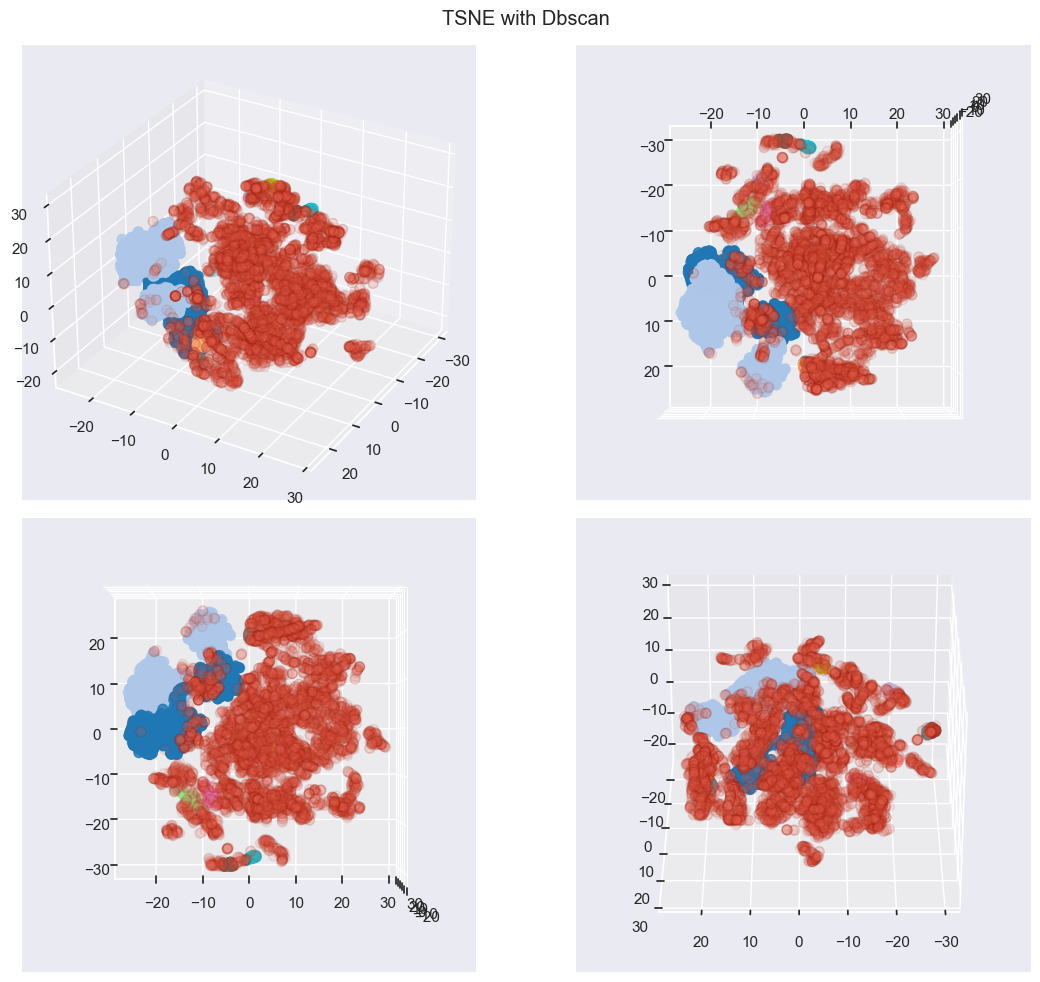

Number of Encoded Features for dsport
3
Number of Encoded Features for proto
3
Number of Encoded Features for sport
3
Number of Encoded Features for srcip
14
Number of Encoded Features for dstip
20


In [6]:
train_data, val_data = get_data(
    size=0.2,
    rs=42,
    threshold=0.1,
    downsample=0.20,
    split_method='shuffle',
    scaler_type='standard',
    plot_clusters=True
    )

In [7]:
print(train_data['attack_cat'].value_counts())
print(val_data['attack_cat'].value_counts())
print(train_data['Label'].value_counts())
print(val_data['Label'].value_counts())

attack_cat
Normal            1429817
Generic            172347
Exploits            35587
Fuzzers             19335
DoS                 13099
Reconnaissance      11212
Analysis             2099
Backdoor             1885
Shellcode            1214
Worms                 133
Name: count, dtype: int64
attack_cat
Normal            357311
Generic            43134
Exploits            8938
Fuzzers             4911
DoS                 3254
Reconnaissance      2775
Analysis             578
Backdoor             444
Shellcode            297
Worms                 41
Name: count, dtype: int64
Label
0    1429817
1     256911
Name: count, dtype: int64
Label
0    357311
1     64372
Name: count, dtype: int64


In [8]:
X_train = train_data.drop(columns=['attack_cat', 'Label'])
y_train = train_data['Label']
train_cat = train_data['attack_cat']
X_val = val_data.drop(columns=['attack_cat', 'Label'])
y_val = val_data['Label']
val_cat = val_data['attack_cat']
rf_classifier = RandomForestClassifier(random_state=42)
rf_classifier.fit(X_train, y_train)
y_pred = rf_classifier.predict(X_val)
print("Accuracy:", accuracy_score(y_val, y_pred))
print("Precision:", precision_score(y_val, y_pred))
print("Recall:", recall_score(y_val, y_pred))
print("F1 Score:", f1_score(y_val, y_pred))
print("\nClassification Report:\n", classification_report(y_val, y_pred))
feature_importances = rf_classifier.feature_importances_
features = X_train.columns
importance_df = pd.DataFrame({
    'Feature': features,
    'Importance': feature_importances
})
top_features = importance_df.sort_values(by='Importance', ascending=False).head(30)
print("\nTop 30 Feature Importances:")
print(top_features)
print("\nAccuracy:", accuracy_score(y_val, y_pred))
print("Precision:", precision_score(y_val, y_pred))
print("Recall:", recall_score(y_val, y_pred))
print("F1 Score:", f1_score(y_val, y_pred))
print("\nClassification Report:\n", classification_report(y_val, y_pred))

Accuracy: 0.9961653659265373
Precision: 0.9869484923258376
Recall: 0.9879450692847822
F1 Score: 0.9874465293574207

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00    357311
           1       0.99      0.99      0.99     64372

    accuracy                           1.00    421683
   macro avg       0.99      0.99      0.99    421683
weighted avg       1.00      1.00      1.00    421683


Top 30 Feature Importances:
                  Feature  Importance
29           ct_state_ttl    0.198920
3                    sttl    0.157871
1                  sbytes    0.083121
15                smeansz    0.059798
4                    dttl    0.044023
8                   Dload    0.041180
16                dmeansz    0.037735
7                   Sload    0.030967
46              state_INT    0.026698
0                     dur    0.025061
88     srcip_175.45.176.1    0.023172
10                  Dpkts    0.020810
24        

In [9]:
val_data['predicted_label'] = y_pred
val_data['true_label'] = y_val
attack_categories = val_data['attack_cat'].unique()
for category in attack_categories:
    print(f"Evaluation for attack category: {category}")
    category_data = val_data[val_data['attack_cat'] == category]
    if len(category_data) == 0:
        print(f"No samples found for category: {category}")
        print("-" * 50)
        continue
    y_true_category = category_data['true_label']
    y_pred_category = category_data['predicted_label']
    correct_predictions = (y_true_category == y_pred_category).sum()
    total_samples = len(y_true_category)
    accuracy = accuracy_score(y_true_category, y_pred_category)
    precision = precision_score(y_true_category, y_pred_category, zero_division=0)
    recall = recall_score(y_true_category, y_pred_category, zero_division=0)
    f1 = f1_score(y_true_category, y_pred_category, zero_division=0)
    print(f"Total samples: {total_samples}")
    print(f"Correct predictions: {correct_predictions}")
    print(f"Accuracy: {accuracy}")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"F1-Score: {f1}")
    print("\nClassification Report:\n", classification_report(y_true_category, y_pred_category, zero_division=0))
    print("-" * 50)

Evaluation for attack category: Normal
Total samples: 357311
Correct predictions: 356470
Accuracy: 0.9976463081181379
Precision: 0.0
Recall: 0.0
F1-Score: 0.0

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00    357311
           1       0.00      0.00      0.00         0

    accuracy                           1.00    357311
   macro avg       0.50      0.50      0.50    357311
weighted avg       1.00      1.00      1.00    357311

--------------------------------------------------
Evaluation for attack category: Generic
Total samples: 43134
Correct predictions: 43129
Accuracy: 0.9998840821625632
Precision: 1.0
Recall: 0.9998840821625632
F1-Score: 0.9999420377218506

Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       1.00      1.00      1.00     43134

    accuracy                           1.00     43134
   macr

# Downsample by 50% of the Normal labels. - 50% of the Normal labels remain.
- Lower accuracy on some labels.

In [11]:
train_data, val_data = get_data(
    size=0.2,
    rs=42,
    threshold=0.1,
    downsample=0.5,
    split_method='shuffle',
    scaler_type='standard',
    plot_clusters=False
    )

C:\Users\adi_s\AppData\Local\Temp\ipykernel_31364\1568988960.py:25: DtypeWarning: Columns (1,3,47) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(f'../UNSW-NB15_{i}.csv', header=None)
C:\Users\adi_s\AppData\Local\Temp\ipykernel_31364\1568988960.py:25: DtypeWarning: Columns (3,39,47) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(f'../UNSW-NB15_{i}.csv', header=None)


Dataset 0
Filtered Rows (Cleaning): 62
Downsampled Rows: 335211
Dataset 1
Filtered Rows (Cleaning): 61
Downsampled Rows: 316986
Dataset 2
Filtered Rows (Cleaning): 105
Downsampled Rows: 258546
Dataset 3
Filtered Rows (Cleaning): 75
Downsampled Rows: 167592
Check Sampling Distribution of Labels:
Full Data:
Average Count of Labels 9.52 with 100 estimators of size 10000
Down-sampled Data:
Average Count of Labels Downsampled Data: 9.68 with 100 estimators of size 10000
Number of Encoded Features for dsport
5
Number of Encoded Features for proto
3
Number of Encoded Features for sport
3
Number of Encoded Features for srcip
14
Number of Encoded Features for dstip
20


In [12]:
print(train_data['attack_cat'].value_counts())

attack_cat
Normal            912178
Generic           172463
Exploits           35388
Fuzzers            19460
DoS                13159
Reconnaissance     11133
Analysis            2134
Backdoor            1879
Shellcode           1192
Worms                141
Name: count, dtype: int64


In [13]:
X_train = train_data.drop(columns=['attack_cat', 'Label'])
y_train = train_data['Label']
train_cat = train_data['attack_cat']
X_val = val_data.drop(columns=['attack_cat', 'Label'])
y_val = val_data['Label']
val_cat = val_data['attack_cat']
rf_classifier = RandomForestClassifier(random_state=42)
rf_classifier.fit(X_train, y_train)
y_pred = rf_classifier.predict(X_val)
print("Accuracy:", accuracy_score(y_val, y_pred))
print("Precision:", precision_score(y_val, y_pred))
print("Recall:", recall_score(y_val, y_pred))
print("F1 Score:", f1_score(y_val, y_pred))
print("\nClassification Report:\n", classification_report(y_val, y_pred))

Accuracy: 0.9949535038079663
Precision: 0.9840446011920346
Recall: 0.9931762365156838
F1 Score: 0.9885893319924187

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00    227948
           1       0.98      0.99      0.99     64334

    accuracy                           0.99    292282
   macro avg       0.99      0.99      0.99    292282
weighted avg       0.99      0.99      0.99    292282



In [14]:
val_data['predicted_label'] = y_pred
val_data['true_label'] = y_val
attack_categories = val_data['attack_cat'].unique()
for category in attack_categories:
    print(f"Evaluation for attack category: {category}")
    category_data = val_data[val_data['attack_cat'] == category]
    if len(category_data) == 0:
        print(f"No samples found for category: {category}")
        print("-" * 50)
        continue
    y_true_category = category_data['true_label']
    y_pred_category = category_data['predicted_label']
    correct_predictions = (y_true_category == y_pred_category).sum()
    total_samples = len(y_true_category)
    accuracy = accuracy_score(y_true_category, y_pred_category)
    precision = precision_score(y_true_category, y_pred_category, zero_division=0)
    recall = recall_score(y_true_category, y_pred_category, zero_division=0)
    f1 = f1_score(y_true_category, y_pred_category, zero_division=0)
    print(f"Total samples: {total_samples}")
    print(f"Correct predictions: {correct_predictions}")
    print(f"Accuracy: {accuracy}")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"F1-Score: {f1}")
    print("\nClassification Report:\n", classification_report(y_true_category, y_pred_category, zero_division=0))
    print("-" * 50)

Evaluation for attack category: Normal
Total samples: 227948
Correct predictions: 226912
Accuracy: 0.9954551037956025
Precision: 0.0
Recall: 0.0
F1-Score: 0.0

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00    227948
           1       0.00      0.00      0.00         0

    accuracy                           1.00    227948
   macro avg       0.50      0.50      0.50    227948
weighted avg       1.00      1.00      1.00    227948

--------------------------------------------------
Evaluation for attack category: DoS
Total samples: 3194
Correct predictions: 3193
Accuracy: 0.9996869129618033
Precision: 1.0
Recall: 0.9996869129618033
F1-Score: 0.9998434319711915

Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       1.00      1.00      1.00      3194

    accuracy                           1.00      3194
   macro avg 

# Downsample by 90% of the Normal labels. - 10% of the Normal labels remain.
- Fixes accuracy to above 99% for all labels except Normal- this might be a problem too?
- Decreases accuracy slightly in Normal labels.

In [15]:
train_data, val_data = get_data(
    size=0.2,
    rs=42,
    threshold=0.1,
    downsample=0.9,
    split_method='shuffle',
    scaler_type='standard',
    plot_clusters=False
    )

C:\Users\adi_s\AppData\Local\Temp\ipykernel_31364\1568988960.py:25: DtypeWarning: Columns (1,3,47) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(f'../UNSW-NB15_{i}.csv', header=None)
C:\Users\adi_s\AppData\Local\Temp\ipykernel_31364\1568988960.py:25: DtypeWarning: Columns (3,39,47) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(f'../UNSW-NB15_{i}.csv', header=None)


Dataset 0
Filtered Rows (Cleaning): 62
Downsampled Rows: 603379
Dataset 1
Filtered Rows (Cleaning): 61
Downsampled Rows: 570575
Dataset 2
Filtered Rows (Cleaning): 105
Downsampled Rows: 465383
Dataset 3
Filtered Rows (Cleaning): 75
Downsampled Rows: 301666
Check Sampling Distribution of Labels:
Full Data:
Average Count of Labels 9.51 with 100 estimators of size 10000
Down-sampled Data:
Average Count of Labels Downsampled Data: 9.96 with 100 estimators of size 10000
Number of Encoded Features for dsport
5
Number of Encoded Features for proto
3
Number of Encoded Features for sport
3
Number of Encoded Features for srcip
17
Number of Encoded Features for dstip
21


In [16]:
val_data['attack_cat'].value_counts()

attack_cat
Normal            55305
Generic           43211
Exploits           9027
Fuzzers            4721
DoS                3330
Reconnaissance     2825
Analysis            546
Backdoor            458
Shellcode           293
Worms                33
Name: count, dtype: int64

In [17]:
X_train = train_data.drop(columns=['attack_cat', 'Label'])
y_train = train_data['Label']
train_cat = train_data['attack_cat']
X_val = val_data.drop(columns=['attack_cat', 'Label'])
y_val = val_data['Label']
val_cat = val_data['attack_cat']
rf_classifier = RandomForestClassifier(random_state=42)
rf_classifier.fit(X_train, y_train)
y_pred = rf_classifier.predict(X_val)
print("Accuracy:", accuracy_score(y_val, y_pred))
print("Precision:", precision_score(y_val, y_pred))
print("Recall:", recall_score(y_val, y_pred))
print("F1 Score:", f1_score(y_val, y_pred))
print("\nClassification Report:\n", classification_report(y_val, y_pred))

Accuracy: 0.9928433640364429
Precision: 0.9878772998603588
Recall: 0.9989603376575011
F1 Score: 0.9933879068906188

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.99      0.99     55305
           1       0.99      1.00      0.99     64444

    accuracy                           0.99    119749
   macro avg       0.99      0.99      0.99    119749
weighted avg       0.99      0.99      0.99    119749



In [18]:
val_data['predicted_label'] = y_pred
val_data['true_label'] = y_val
attack_categories = val_data['attack_cat'].unique()
for category in attack_categories:
    print(f"Evaluation for attack category: {category}")
    category_data = val_data[val_data['attack_cat'] == category]
    if len(category_data) == 0:
        print(f"No samples found for category: {category}")
        print("-" * 50)
        continue
    y_true_category = category_data['true_label']
    y_pred_category = category_data['predicted_label']
    correct_predictions = (y_true_category == y_pred_category).sum()
    total_samples = len(y_true_category)
    accuracy = accuracy_score(y_true_category, y_pred_category)
    precision = precision_score(y_true_category, y_pred_category, zero_division=0)
    recall = recall_score(y_true_category, y_pred_category, zero_division=0)
    f1 = f1_score(y_true_category, y_pred_category, zero_division=0)
    print(f"Total samples: {total_samples}")
    print(f"Correct predictions: {correct_predictions}")
    print(f"Accuracy: {accuracy}")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"F1-Score: {f1}")
    print("\nClassification Report:\n", classification_report(y_true_category, y_pred_category, zero_division=0))
    print("-" * 50)

Evaluation for attack category: Normal
Total samples: 55305
Correct predictions: 54515
Accuracy: 0.9857155772534129
Precision: 0.0
Recall: 0.0
F1-Score: 0.0

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.99      0.99     55305
           1       0.00      0.00      0.00         0

    accuracy                           0.99     55305
   macro avg       0.50      0.49      0.50     55305
weighted avg       1.00      0.99      0.99     55305

--------------------------------------------------
Evaluation for attack category: Fuzzers
Total samples: 4721
Correct predictions: 4670
Accuracy: 0.9891972039822071
Precision: 1.0
Recall: 0.9891972039822071
F1-Score: 0.9945692684485146

Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       1.00      0.99      0.99      4721

    accuracy                           0.99      4721
   macro av